# Loading the data

In [19]:
# @title Install dependencies

# !pip install pandas --quiet
# !pip install seaborn --quiet
# !pip install  pyarrow # may be needed to read data file

In [20]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import PCA             # just if needed
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [21]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [22]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

# DATA_ PROCESSING: Start here after loading data

In [23]:
#THIS IS WHERE THE FUN STARTS
# Define a function to map combinations to numbers 1-4
def map_conditions(row):
    if row['exposure_level'] == "familiar" and row['is_change'] == True:
        return 1
    elif row['exposure_level'] == "familiar" and row['is_change'] == False:
        return 2
    elif row['exposure_level'] == "novel" and row['is_change'] == True:
        return 3
    elif row['exposure_level'] == "novel" and row['is_change'] == False:
        return 4


# Apply the function to create the new column
#filtered_df['condition'] = filtered_df.apply(map_conditions, axis=1)

#print(filtered_df.shape)

In [24]:
data['condition'] = data.apply(map_conditions, axis=1)

In [25]:
def restrict_neurons_with_all_conditions(df):
    # Group by neuron and find unique conditions for each neuron
    neuron_conditions = df.groupby('cell_specimen_id')['condition'].unique()
    # filtering only neurons that have trials in all 4 conditions
    neurons_with_all_conditions = neuron_conditions[
        neuron_conditions.apply(lambda x: {1, 2, 3, 4}.issubset(x))
    ].index
    # Filter the data for those neurons
    filtered_d = df[df['cell_specimen_id'].isin(neurons_with_all_conditions)]
    return filtered_d
filtered_data = restrict_neurons_with_all_conditions(data)

In [26]:
def verify_filtered_data(df):
    condition_counts = df.groupby('cell_specimen_id')['condition'].nunique()
    return (condition_counts == 4).all()
print(f"Verification result: {verify_filtered_data(filtered_data)}")

Verification result: True


In [27]:
#how many trials of each type per neuron? -> calculate length of each condition for each neuron - creating the trial counts variable
# Group by cell_id and 'condition', then count the number of occurrences
trial_counts = filtered_data.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts)


     cell_specimen_id  condition  trial_count
0          1086489847          1          204
1          1086489847          2          190
2          1086489847          3          218
3          1086489847          4          217
4          1086489860          1          204
..                ...        ...          ...
383        1086567017          4          184
384        1086567589          1          512
385        1086567589          2          328
386        1086567589          3          352
387        1086567589          4          184

[388 rows x 3 columns]


In [28]:
# Group by 'condition' and find the minimum 'trial_count' for each condition
min_trial_counts = trial_counts.groupby('condition')['trial_count'].min().reset_index()

# For each condition, find the neuron_id corresponding to the minimum trial_count
#min_trial_neurons = trial_counts.loc[trial_counts.groupby('condition')['trial_count'].idxmin()].reset_index(drop=True)

# Merge the two dataframes to get the condition, trial_count, and neuron_id together
#result = pd.merge(min_trial_counts, min_trial_neurons, on=['condition', 'trial_count'], suffixes=('', '_min'))

# Select only the relevant columns
min_trial_counts = min_trial_counts[['condition', 'trial_count']]

print(min_trial_counts)

   condition  trial_count
0          1          122
1          2          150
2          3           82
3          4          146


In [29]:
#ALTERNATIVE OPTION
# Sort the dataframe by 'condition' and 'trial_count' - in case we did not want the minimum but another benchmark
sorted_trial_counts = trial_counts.sort_values(by=['condition', 'trial_count'])

# Group by 'condition' and take the nth smallest 'trial_count'
second_trial_counts = sorted_trial_counts.groupby('condition').nth(0).reset_index()

print(second_trial_counts)

   condition  cell_specimen_id  trial_count
0          1        1086498976          122
1          2        1086562780          150
2          3        1086490603           82
3          4        1086490603          146


Now we need to get all neurons to have the same number of trials per condition. 

In [30]:
#CALCULATE MIN TRIALS
# Calculate the minimum number of trials for each condition
min_trials_per_condition = trial_counts.groupby('condition')['trial_count'].min()
min_trials_per_condition

condition
1    122
2    150
3     82
4    146
Name: trial_count, dtype: int64

In [31]:
#MIN_TRIALS DICTIONARY
# Convert min_trials_df to a dictionary for quick lookup
min_trials_dict = min_trials_per_condition.to_dict()
print(min_trials_dict)

{1: 122, 2: 150, 3: 82, 4: 146}


In [32]:
# Function to sample trials
def sample_trials(group, min_trials_dict, random_seed=42):
    condition = group['condition'].iloc[0]  # Extract condition from group
    min_trials = min_trials_dict.get(condition, None)  # Get minimum trials for the condition
    if min_trials is not None and len(group) > min_trials:
        return group.sample(min_trials, random_state=random_seed)
    return group
    

In [40]:
# Group by 'cell_id' and 'condition', then sample trials to match the minimum
balanced_df = (
    filtered_data.groupby(['cell_specimen_id', 'condition'], group_keys=False)
    .apply(lambda x: sample_trials(x, min_trials_dict))
)

#print(balanced_df)

In [41]:
#CHECKS WHETHER THINGS WORKED
#how many trials of each type per neuron? -> calculate length of each condition for each neuron
# Group by cell_id and 'condition', then count the number of occurrences
print(min_trials_dict)
trial_counts_balanced = balanced_df.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts_balanced) # ToDo: trial_counts_balanced

{1: 122, 2: 150, 3: 82, 4: 146}
     cell_specimen_id  condition  trial_count
0          1086489847          1          122
1          1086489847          2          150
2          1086489847          3           82
3          1086489847          4          146
4          1086489860          1          122
..                ...        ...          ...
383        1086567017          4          146
384        1086567589          1          122
385        1086567589          2          150
386        1086567589          3           82
387        1086567589          4          146

[388 rows x 3 columns]


array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>]],
      dtype=object)

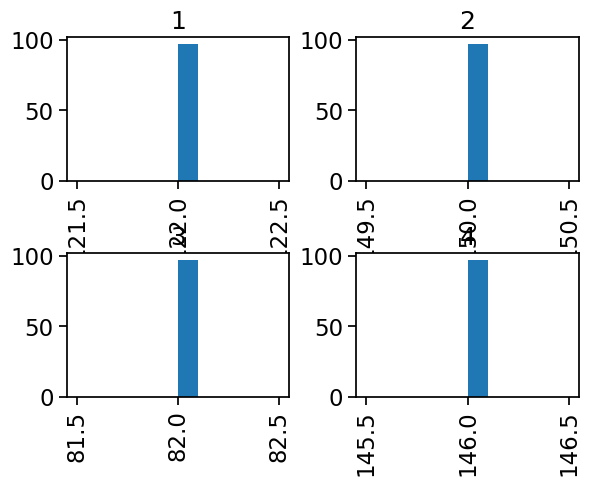

In [43]:
trial_counts_balanced.hist(column='trial_count', by="condition")

In [44]:
# Check if all neurons have the minimum number of trials per condition
correct_counts = trial_counts_balanced.groupby('condition')['trial_count'].nunique() == 1

print("All neurons have the same number of trials per condition:")
print(correct_counts)

All neurons have the same number of trials per condition:
condition
1    True
2    True
3    True
4    True
Name: trial_count, dtype: bool


In [45]:
### Detect outliers ###
# TODO
#outliers = []
#data_traces = data_subset.trace.values
#for i in range(len(data_subset)):
#    outliers.append((data_traces[i]<1).all())
#data_subset_rmo = data_subset[outliers]

In [39]:
trial_counts_balanced.head()

,cell_specimen_id,condition,trial_count
0,1086489847,1,122
1,1086489847,2,150
2,1086489847,3,82
3,1086489847,4,146
4,1086489860,1,122


In [57]:
# X | Y
balanced_df.loc[:,['trace','condition']].sample(10)
# Christine:
# for t in range(timepoints): 
#    X(t) = balanced_df.trace.values[t]


# X(idx:neurons, trial_trace, timepoints)
balanced_df.

,trace,condition
104523,"[0.17610223591327667, 0.1075032502412796, 0.28...",2
1270427,"[-0.09896284341812134, 0.06752821803092957, -0...",1
1669427,"[-0.006669150199741125, -0.06207539141178131, ...",3
1559591,"[0.24728597700595856, 0.23400387167930603, 0.2...",2
523341,"[-0.014786978252232075, 0.04161570593714714, 0...",2
969823,"[-0.00782690104097128, 0.06935980916023254, -0...",4
353277,"[-0.008524744771420956, 0.04017982631921768, 0...",2
886074,"[-0.12369208037853241, 0.02164766564965248, -0...",2
1426076,"[0.009964363649487495, 0.005303954239934683, -...",4
1348813,"[0.13012681901454926, -0.026859629899263382, 0...",1


In [ ]:
### Split the data into training and test sets ###
#clean_data_train, clean_data_test = train_test_split(
#    clean_data,
#    test_size = 0.3, 
#    random_state = 0
#)

C: "At the moment, we have:balanced_df where each row is a trial, several trials per neuron are concatenated in rows (neurons can be indexed by column cell_specimen_id), and timepoints-wise trace values are in an array in the column trace.We want:X: a three-dimensional array containing the trace-values where the first dimension are neurons, the second dimension are trials, and the third dimension are timepoints."

"So X should be an array of shape (97, 432, 85)" -> (neurons, time points, )
"I.e. for each neuron balanced_df[balanced_df.cell_specimen_id==cell_id] will give you all of that cell’s trials"

N = len(balanced_df.cell_specimen_id.unique())S = sum(min_trial_counts.trial_count)T = len(balanced_df.trace.values[0])X = np.zeros((N,S,T))for n, cell_id in enumerate(balanced_df.cell_specimen_id.unique()):    neuron_data = balanced_df[balanced_df.cell_specimen_id==cell_id]    for s in range(S):        for t in range(T):            X[n,s,t] = neuron_data.trace.values[s][t]

In [ ]:
### Logistic Regression Models ###

# Create a pipeline for Logistic Regression 
pipe_logistic = make_pipeline([
    ('std', StandardScaler()), # 'pca', PCA(n_components = 0.9) # just if needed to reduce noise or improve the prediction(s)
    ('logReg', LogisticRegressionCV(random_state = 0, cv = 10)) # 10 fold cross validation
   ])

# Train one model at each time point and save their prediction accuracy 
T = balanced_df.shape[2] # TODO: check structure beforehand 
acc = np.zeros(T)
conf_mat = np.zeros((4,4,T))
for t in range(T):

    ## TODO: Specify x and y for the logistic regression 
    # This is where we can initialize the data frame for t:
    # 
    # Get current numpy array
    # arr = X_train[...]
    #
    # Convert the numpy array to a pandas DataFrame
    #df = pd.DataFrame(arr, columns=['Column1', 'Column2', 'Column3'])
    #
    # Set 'Column1' as the new index
    #df.set_index('Column1', inplace=True)
    
    
    # ...for training
    x_train = clean_data_train.loc[t,'columnName']
    y_train = clean_data_train.loc[t,'columnName']
    # ...for testing
    x_pred = clean_data_train.loc[t,'columnName']
    y_pred = clean_data_train.loc[t,'columnName']
       
    # Fit 
    pipe_logistic.fit(x_train, y_train)

    # Predict
    y_pred = pipe_logistic.predict(X_test)

    # Store accuracy of this prediction
    acc[t] = accuracy_score(y_test, y_pred) # = sum(y_pred[t]==y_test)/len(y_test)
    conf_mat[:,:,t] = confusion_matrix(y_test, y_pred[t])

end 